# Linear Regression Starter Kit for Kaggle House Prices 

## Imports and inits

In [1]:
import h2o
h2o.init(max_mem_size='12G') # give h2o as much memory as possible
h2o.remove_all()
h2o.no_progress() # turn off h2o progress bars

import numpy as np
import pandas as pd

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_71"; Java(TM) SE Runtime Environment (build 1.8.0_71-b15); Java HotSpot(TM) 64-Bit Server VM (build 25.71-b15, mixed mode)
  Starting server from /Users/naveen/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/4n/h7xb1dtn49j2_x4sr6srz3gh0000gn/T/tmpu1d6eczx
  JVM stdout: /var/folders/4n/h7xb1dtn49j2_x4sr6srz3gh0000gn/T/tmpu1d6eczx/h2o_naveen_started_from_python.out
  JVM stderr: /var/folders/4n/h7xb1dtn49j2_x4sr6srz3gh0000gn/T/tmpu1d6eczx/h2o_naveen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.10.2.2
H2O cluster version age:,4 months and 20 days !!!
H2O cluster name:,H2O_from_python_naveen_ov54p6
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


## Import data

In [2]:
train = h2o.import_file('../KaggleHousePrices/train.csv')
test = h2o.import_file('../KaggleHousePrices/test.csv')

#### Determine data types

In [3]:
def get_type_lists(frame=train, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [4]:
original_nums, cats = get_type_lists()

Numeric = ['MiscVal', 'YrSold', 'GarageArea', 'MSSubClass', 'OverallQual', 'BsmtFinSF2', 'PoolArea', 'GarageYrBlt', 'TotalBsmtSF', 'LotArea', 'WoodDeckSF', 'ScreenPorch', 'GarageCars', 'FullBath', 'GrLivArea', 'BsmtFinSF1', 'OverallCond', '3SsnPorch', '1stFlrSF', 'BsmtHalfBath', 'TotRmsAbvGrd', 'HalfBath', 'EnclosedPorch', 'MoSold', 'LowQualFinSF', '2ndFlrSF', 'YearBuilt', 'LotFrontage', 'BsmtUnfSF', 'BedroomAbvGr', 'BsmtFullBath', 'Fireplaces', 'MasVnrArea', 'KitchenAbvGr', 'YearRemodAdd', 'OpenPorchSF']

Categorical = ['Exterior1st', 'KitchenQual', 'SaleCondition', 'GarageType', 'Fence', 'MasVnrType', 'MiscFeature', 'Exterior2nd', 'Utilities', 'ExterQual', 'LandContour', 'BsmtCond', 'HouseStyle', 'CentralAir', 'HeatingQC', 'Neighborhood', 'BsmtQual', 'Alley', 'LotConfig', 'BsmtFinType1', 'Foundation', 'PavedDrive', 'ExterCond', 'Heating', 'RoofMatl', 'RoofStyle', 'Street', 'SaleType', 'GarageQual', 'Electrical', 'LotShape', 'Condition2', 'Functional', 'BsmtExposure', 'MSZoning', 'Lan

## Impute numeric missing

In [5]:
# median usually better than mean
# (_ signifies temporary throw-away variable, used to suppress output)
_ = train[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = test[['BsmtHalfBath', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtUnfSF', 'MasVnrArea', 
          'GarageYrBlt', 'LotFrontage', 'GarageCars', 'TotalBsmtSF', 'GarageArea']].impute(method='median')

## Encode categorical using shrunken averages
http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.ps

In [6]:
def target_encoder(training_frame, test_frame, x, y, lambda_=0.15, threshold=150, test=False):
    
    """ Applies simple target encoding to categorical variables.
    
    :param training_frame: Training frame which to create target means and to be encoded.
    :param test_frame: Test frame to be encoded using information from training frame.
    :param x: Name of input variable to be encoded.
    :param y: Name of target variable to use for encoding.
    :param lambda_: Balance between level mean and overall mean for small groups.
    :param threshold: Number below which a level is considered small enough to be shrunken.
    :param test: Whether or not to print the row_val_dict for testing purposes.
    :return: Tuple of encoded variable from train and test set as H2OFrames. 
    
    """
    
    # convert to pandas
    trdf = training_frame.as_data_frame().loc[:, [x,y]] # df
    tss = test_frame.as_data_frame().loc[:, x]          # series

    
    # create dictionary of level:encode val
    
    encode_name = x + '_Tencode'
    overall_mean = trdf[y].mean()
    row_val_dict = {}

    for level in trdf[x].unique():
        level_df = trdf[trdf[x] == level][y]
        level_n = level_df.shape[0]
        level_mean = level_df.mean()
        if level_n >= threshold:
            row_val_dict[level] = level_mean
        else:
            row_val_dict[level] = ((1 - lambda_) * level_mean) +\
                                  (lambda_ * overall_mean)
                
    row_val_dict[np.nan] = overall_mean # handle missing values
    
    if test:
        print(row_val_dict)
        
    # apply the transform to training data
    trdf[encode_name] = trdf[x].apply(lambda i: row_val_dict[i])   
    
    # apply the transform to test data
    tsdf = pd.DataFrame(columns=[x, encode_name])
    tsdf[x] = tss
    tsdf.loc[:, encode_name] = overall_mean # handle previously unseen values
    tsdf[encode_name] = tsdf[x].apply(lambda i: row_val_dict[i])
    
    # convert back to H2O
    
    trdf = h2o.H2OFrame(trdf[encode_name].as_matrix())
    trdf.columns = [encode_name]
    
    tsdf = h2o.H2OFrame(tsdf[encode_name].as_matrix())
    tsdf.columns = [encode_name]
    
    return (trdf, tsdf)


#### Execute encoding

In [7]:
for i, var in enumerate(cats):
    
    total = len(cats)
    tr_enc, ts_enc = target_encoder(train, test, var, 'SalePrice')

    print('Encoding: ' + var + ' (' + str(i+1) + '/' + str(total) + ') ...')

    train = train.cbind(tr_enc)
    test = test.cbind(ts_enc)    
    
print('Done.')

Encoding: Exterior1st (1/43) ...
Encoding: KitchenQual (2/43) ...
Encoding: SaleCondition (3/43) ...
Encoding: GarageType (4/43) ...
Encoding: Fence (5/43) ...
Encoding: MasVnrType (6/43) ...
Encoding: MiscFeature (7/43) ...
Encoding: Exterior2nd (8/43) ...
Encoding: Utilities (9/43) ...
Encoding: ExterQual (10/43) ...
Encoding: LandContour (11/43) ...
Encoding: BsmtCond (12/43) ...
Encoding: HouseStyle (13/43) ...
Encoding: CentralAir (14/43) ...
Encoding: HeatingQC (15/43) ...
Encoding: Neighborhood (16/43) ...
Encoding: BsmtQual (17/43) ...
Encoding: Alley (18/43) ...
Encoding: LotConfig (19/43) ...
Encoding: BsmtFinType1 (20/43) ...
Encoding: Foundation (21/43) ...
Encoding: PavedDrive (22/43) ...
Encoding: ExterCond (23/43) ...
Encoding: Heating (24/43) ...
Encoding: RoofMatl (25/43) ...
Encoding: RoofStyle (26/43) ...
Encoding: Street (27/43) ...
Encoding: SaleType (28/43) ...
Encoding: GarageQual (29/43) ...
Encoding: Electrical (30/43) ...
Encoding: LotShape (31/43) ...
Encodin

#### Redefine numerics and explore

In [8]:
encoded_nums, cats = get_type_lists(frame=train)

Numeric = ['MiscVal', 'YrSold', 'Exterior1st_Tencode', 'GarageArea', 'MSSubClass', 'OverallQual', 'BsmtFinSF2', 'BsmtFinType2_Tencode', 'Condition2_Tencode', 'MasVnrType_Tencode', 'PoolArea', 'GarageYrBlt', 'GarageQual_Tencode', 'TotalBsmtSF', 'Functional_Tencode', 'Heating_Tencode', 'LotArea', 'BsmtCond_Tencode', 'WoodDeckSF', 'LotConfig_Tencode', 'Alley_Tencode', 'SaleCondition_Tencode', 'MSZoning_Tencode', 'ScreenPorch', 'GarageCars', 'GarageType_Tencode', 'FullBath', 'KitchenQual_Tencode', 'BsmtFinSF1', 'Electrical_Tencode', 'OverallCond', 'GrLivArea', 'LotShape_Tencode', '3SsnPorch', '1stFlrSF', 'BsmtHalfBath', 'TotRmsAbvGrd', 'HalfBath', 'Fireplaces', 'SaleType_Tencode', 'EnclosedPorch', 'BsmtExposure_Tencode', 'MiscFeature_Tencode', 'Foundation_Tencode', 'PavedDrive_Tencode', 'FireplaceQu_Tencode', 'CentralAir_Tencode', 'MoSold', 'LowQualFinSF', '2ndFlrSF', 'HeatingQC_Tencode', 'ExterCond_Tencode', 'PoolQC_Tencode', 'KitchenAbvGr', 'LandSlope_Tencode', 'YearBuilt', 'Fence_Tencod

In [9]:
print('Imputed and encoded numeric training data:')
train[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric test data:')
test[encoded_nums].describe() #79 numeric columns w/ no missing

Imputed and encoded numeric training data:
Rows:1460
Cols:79




,MiscVal,YrSold,Exterior1st_Tencode,GarageArea,MSSubClass,OverallQual,BsmtFinSF2,BsmtFinType2_Tencode,Condition2_Tencode,MasVnrType_Tencode,PoolArea,GarageYrBlt,GarageQual_Tencode,TotalBsmtSF,Functional_Tencode,Heating_Tencode,LotArea,BsmtCond_Tencode,WoodDeckSF,LotConfig_Tencode,Alley_Tencode,SaleCondition_Tencode,MSZoning_Tencode,ScreenPorch,GarageCars,GarageType_Tencode,FullBath,KitchenQual_Tencode,BsmtFinSF1,Electrical_Tencode,OverallCond,GrLivArea,LotShape_Tencode,3SsnPorch,1stFlrSF,BsmtHalfBath,TotRmsAbvGrd,HalfBath,Fireplaces,SaleType_Tencode,EnclosedPorch,BsmtExposure_Tencode,MiscFeature_Tencode,Foundation_Tencode,PavedDrive_Tencode,FireplaceQu_Tencode,CentralAir_Tencode,MoSold,LowQualFinSF,2ndFlrSF,HeatingQC_Tencode,ExterCond_Tencode,PoolQC_Tencode,KitchenAbvGr,LandSlope_Tencode,YearBuilt,Fence_Tencode,Exterior2nd_Tencode,LandContour_Tencode,Condition1_Tencode,LotFrontage,ExterQual_Tencode,BsmtUnfSF,BsmtQual_Tencode,HouseStyle_Tencode,BedroomAbvGr,BsmtFullBath,Utilities_Tencode,OpenPorchSF,Street_Tencode,MasVnrArea,Neighborhood_Tencode,GarageCond_Tencode,YearRemodAdd,BsmtFinType1_Tencode,RoofStyle_Tencode,BldgType_Tencode,RoofMatl_Tencode,GarageFinish_Tencode
type,int,int,real,int,int,int,int,real,real,real,int,real,real,int,real,real,int,real,int,real,real,real,real,int,int,real,int,real,int,real,int,int,real,int,int,int,int,int,int,real,int,real,real,real,real,real,real,int,int,int,real,real,real,int,real,int,real,real,real,real,real,real,int,real,real,int,int,real,int,real,real,real,real,int,real,real,real,real,real
mins,0.0,2006.0,87488.17938356164,0.0,20.0,1.0,0.0,155574.02938356163,109375.67938356163,151508.53605022831,0.0,1900.0,112279.84605022831,0.0,100068.17938356164,88763.17938356164,1300.0,81538.17938356164,0.0,176938.0475285171,131024.39738356163,115644.42938356163,90486.97938356163,0.0,0.0,120605.97382800607,0.0,116868.60374253601,0.0,84088.17938356164,1.0,334.0,164754.81837837838,0.0,334.0,0.0,2.0,0.0,0.0,129010.67938356163,0.0,165652.29590766,107038.17938356163,118398.96063356163,124921.43327245054,137437.70688356162,116612.64201514059,1.0,0.0,0.0,101088.17938356164,92163.17938356164,180921.19589041095,0.0,179956.7995658466,1872.0,141281.58847447074,116388.17938356163,148776.6468438791,141966.09605022828,21.0,101925.61152641877,0.0,125476.40366927591,120765.67938356163,0.0,0.0,144013.17938356166,0.0,137800.10438356164,0.0,110928.17938356163,119363.17938356163,1950.0,151994.04028581732,153710.9066562889,136305.59873840035,143588.17938356166,142156.42314049587
mean,43.489041095890414,2007.8157534246575,180880.5669704916,472.9801369863014,56.897260273972606,6.0993150684931505,46.54931506849315,182969.4818640458,180958.0448224338,179556.69860888534,2.758904109589041,1978.5061638868744,185465.54685972977,1057.4294520547949,181271.62194407952,181082.5793769,10516.82808219178,182907.7643074686,94.2445205479452,180509.6631237099,178903.9882177238,180217.29174554325,180890.65145472882,15.060958904109588,1.7671232876712328,184682.717467067,1.5650684931506849,179706.3537221336,443.6397260273973,181738.16977317512,5.575342465753424,1515.463698630137,180636.96109490524,3.4095890410958902,1162.626712328767,0.057534246575342465,6.517808219178082,0.38287671232876713,0.613013698630137,179942.39162399143,21.954109589041096,181624.85937051979,180000.13846481516,181839.77812305308,181680.14683289544,199396.0979636423,181659.6301311222,6.321917808219178,5.844520547945206,346.99246575342465,181217.80597203973,181331.30861662602,181358.14341400826,1.0465753424657533,180784.26482323132,1971.267808219178,175820.09948517542,181031.77015866013,180821.86755352787,181383.89587446052,70.04995836802664,180058.8228693939,567.2404109589039,181246.74738478137,181286.7320662882,2.8664383561643834,0.42534246575342466,180925.6569721805,46.66027397260274,180952.46823719272,103.68526170798899,180373.08053504408,185529.60426332333,1984.8657534246574,183992.57690349972,180930.1805271627,181528.18075483205,180756.55353696752,185226.6184021392


--------------------------------------------------------------------------------
Imputed and encoded numeric test data:
Rows:1459
Cols:79




,MiscVal,YrSold,Exterior1st_Tencode,GarageArea,MSSubClass,OverallQual,BsmtFinSF2,BsmtFinType2_Tencode,Condition2_Tencode,MasVnrType_Tencode,PoolArea,GarageYrBlt,GarageQual_Tencode,TotalBsmtSF,Functional_Tencode,Heating_Tencode,LotArea,BsmtCond_Tencode,WoodDeckSF,LotConfig_Tencode,Alley_Tencode,SaleCondition_Tencode,MSZoning_Tencode,ScreenPorch,GarageCars,GarageType_Tencode,FullBath,KitchenQual_Tencode,BsmtFinSF1,Electrical_Tencode,OverallCond,GrLivArea,LotShape_Tencode,3SsnPorch,1stFlrSF,BsmtHalfBath,TotRmsAbvGrd,HalfBath,Fireplaces,SaleType_Tencode,EnclosedPorch,BsmtExposure_Tencode,MiscFeature_Tencode,Foundation_Tencode,PavedDrive_Tencode,FireplaceQu_Tencode,CentralAir_Tencode,MoSold,LowQualFinSF,2ndFlrSF,HeatingQC_Tencode,ExterCond_Tencode,PoolQC_Tencode,KitchenAbvGr,LandSlope_Tencode,YearBuilt,Fence_Tencode,Exterior2nd_Tencode,LandContour_Tencode,Condition1_Tencode,LotFrontage,ExterQual_Tencode,BsmtUnfSF,BsmtQual_Tencode,HouseStyle_Tencode,BedroomAbvGr,BsmtFullBath,Utilities_Tencode,OpenPorchSF,Street_Tencode,MasVnrArea,Neighborhood_Tencode,GarageCond_Tencode,YearRemodAdd,BsmtFinType1_Tencode,RoofStyle_Tencode,BldgType_Tencode,RoofMatl_Tencode,GarageFinish_Tencode
type,int,int,real,real,int,int,real,real,real,real,int,real,real,real,real,real,int,real,int,real,real,real,real,int,real,real,int,real,real,real,int,int,real,int,int,real,int,int,int,real,int,real,real,real,real,real,real,int,int,int,real,real,real,int,real,int,real,real,real,real,real,real,real,real,real,int,real,real,int,real,real,real,real,int,real,real,real,real,real
mins,0.0,2006.0,87488.17938356164,0.0,20.0,1.0,0.0,155574.02938356163,117663.17938356163,151508.53605022831,0.0,1895.0,112279.84605022831,0.0,100068.17938356164,91118.89366927592,1470.0,81538.17938356164,0.0,176938.0475285171,131024.39738356163,115644.42938356163,90486.97938356163,0.0,0.0,120605.97382800607,0.0,116868.60374253601,0.0,109871.51271689495,1.0,407.0,164754.81837837838,0.0,407.0,0.0,3.0,0.0,0.0,129010.67938356163,0.0,165652.29590766,107038.17938356163,118398.96063356163,124921.43327245054,137437.70688356162,116612.64201514059,1.0,0.0,0.0,101088.17938356164,92163.17938356164,180921.19589041095,0.0,179956.7995658466,1879.0,141281.58847447074,116388.17938356163,148776.6468438791,141966.09605022828,21.0,101925.61152641877,0.0,125476.40366927591,120765.67938356163,0.0,0.0,180921.19589041095,0.0,137800.10438356164,0.0,110928.17938356163,119363.17938356163,1950.0,151994.04028581732,153710.9066562889,136305.59873840035,179803.6792189679,142156.42314049587
mean,58.16792323509253,2007.7697052775875,180163.89739622173,472.7688614540466,57.37834132967786,6.078821110349555,52.61934156378601,183200.1159337163,181166.03732137333,178895.07396658702,1.7443454420836186,1977.7212165097756,184312.7546957362,1046.1179698216736,181323.95712586772,181709.87824014013,9819.161069225496,182176.83677290616,93.17477724468814,180234.8138259489,178248.7290662322,179879.14016561164,179772.83366709028,17.064427690198766,1.766117969821674,184656.7295734541,1.570938999314599,179420.17532378223,439.2037037037037,181890.53298830043,5.5538039753255655,1486.0459218642907,180249.28067462493,1.794379712131597,1156.534612748458,0.06520247083047358,6.385195339273475,0.3776559287183002,0.5812200137080191,179613.55995767802,24.24331734064428,181657.00791990335,180005.30438727606,182394.1607868111,180094.92690285092,197633.53114565878,181370.41046901883,6.104180945853324,3.5435229609321452,325.96778615490064,181724.34342026233,180735.6325431525,181293.60332733998,1.0424948594928032,180592.19026393845,1971.357779300891,175663.07479793802,180766.37959959696,181450.84022501088,181389.31663321095,68.58035714285714,180460.36175619633,554.2949245541838,181935.06349994175,180645.50750293158,2.8540095956134337,0.4344543582704186,180950.9160234005,48.3139136394791,180952.34618765383,100.70914127423823,178691.23051399062,185422.7774534009,1983.6627827278958,184645.88361245437,180180.92858796637,181077.96729000125,180110.94715035177,18482

In [10]:
# Check Neighborhood_Tencode

print(test[0:5, ['Neighborhood', 'Neighborhood_Tencode']])
_, _ = target_encoder(train, test, 'Neighborhood', 'SalePrice', test=True)
del _

# NAmes   145847
# NAmes   145847
# Gilbert 191064
# Gilbert 191064
# StoneBr 291062

Neighborhood,Neighborhood_Tencode
NAmes,145847
NAmes,145847
Gilbert,191065
Gilbert,191065
StoneBr,291062



{nan: 180921.19589041095, 'BrDale': 115957.86688356164, 'Mitchel': 159967.78346519428, 'MeadowV': 110928.17938356164, 'Veenker': 230094.99756537983, 'CollgCr': 197965.77333333335, 'Crawfor': 206169.19605022832, 'NoRidge': 312139.1988957568, 'OldTown': 136129.68513577402, 'IDOTRR': 112243.39559977785, 'Gilbert': 191064.5097633085, 'Sawyer': 143412.3442484265, 'BrkSide': 133247.12334907887, 'ClearCr': 207818.79366927594, 'Edwards': 136124.92438356165, 'Blmngtn': 192778.42938356166, 'NAmes': 145847.08, 'Blueste': 144013.17938356166, 'SWISU': 148340.8353835616, 'NWAmes': 187830.7376027397, 'Somerst': 218711.04101146862, 'Timber': 233048.5096467195, 'SawyerW': 185710.60650220572, 'StoneBr': 291062.3293835616, 'NridgHt': 295968.20925369154, 'NPkVill': 148428.4571613394}


## Create combination features

In [11]:
def feature_combiner(training_frame, test_frame, nums):
    
    """ Combines numeric features using simple arithmatic operations.
    
    :param training_frame: Training frame from which to generate features and onto which generated 
                           feeatures will be cbound.
    :param test_frame: Test frame from which to generate features and onto which generated 
                       feeatures will be cbound.
    :param nums: List of original numeric features from which to generate combined features.
    
    """

    total = len(nums)
    
    # convert to pandas
    train_df = training_frame.as_data_frame()
    test_df = test_frame.as_data_frame()
    
    for i, col_i in enumerate(nums):
        
        print('Combining: ' + col_i + ' (' + str(i+1) + '/' + str(total) + ') ...')        
        
        for j, col_j in enumerate(nums):
            
            # don't repeat (i*j = j*i)
            if i < j:
                
                # convert to pandas
                col_i_train_df = train_df[col_i]
                col_j_train_df = train_df[col_j]
                col_i_test_df = test_df[col_i]
                col_j_test_df = test_df[col_j] 

                # multiply, convert back to h2o
                train_df[str(col_i + '|' + col_j)] = col_i_train_df.values*col_j_train_df.values
                test_df[str(col_i + '|' + col_j)] = col_i_test_df.values*col_j_test_df.values
                
    print('Done.')
    
    # convert back to h2o
    
    print('Converting to H2OFrame ...')
    
    training_frame = h2o.H2OFrame(train_df)
    training_frame.columns = list(train_df)
    test_frame = h2o.H2OFrame(test_df)
    test_frame.columns = list(test_df)
    
    print('Done.')
    
    # conserve memory 
    del train_df
    del test_df 
    
    return training_frame, test_frame


In [12]:
train, test = feature_combiner(train, test, encoded_nums)

Combining: MiscVal (1/79) ...
Combining: YrSold (2/79) ...
Combining: Exterior1st_Tencode (3/79) ...
Combining: GarageArea (4/79) ...
Combining: MSSubClass (5/79) ...
Combining: OverallQual (6/79) ...
Combining: BsmtFinSF2 (7/79) ...
Combining: BsmtFinType2_Tencode (8/79) ...
Combining: Condition2_Tencode (9/79) ...
Combining: MasVnrType_Tencode (10/79) ...
Combining: PoolArea (11/79) ...
Combining: GarageYrBlt (12/79) ...
Combining: GarageQual_Tencode (13/79) ...
Combining: TotalBsmtSF (14/79) ...
Combining: Functional_Tencode (15/79) ...
Combining: Heating_Tencode (16/79) ...
Combining: LotArea (17/79) ...
Combining: BsmtCond_Tencode (18/79) ...
Combining: WoodDeckSF (19/79) ...
Combining: LotConfig_Tencode (20/79) ...
Combining: Alley_Tencode (21/79) ...
Combining: SaleCondition_Tencode (22/79) ...
Combining: MSZoning_Tencode (23/79) ...
Combining: ScreenPorch (24/79) ...
Combining: GarageCars (25/79) ...
Combining: GarageType_Tencode (26/79) ...
Combining: FullBath (27/79) ...
Comb

#### Redefine numerics and explore

In [13]:
encoded_combined_nums, cats = get_type_lists(frame=train)

Numeric = ['YearBuilt|Neighborhood_Tencode', 'WoodDeckSF|OpenPorchSF', 'PoolArea', 'OverallQual|EnclosedPorch', 'Exterior1st_Tencode|GarageYrBlt', 'SaleType_Tencode|LotFrontage', 'WoodDeckSF|BsmtQual_Tencode', 'BsmtCond_Tencode|BsmtFullBath', 'Foundation_Tencode|2ndFlrSF', 'BsmtFinSF1|YearRemodAdd', 'GarageYrBlt|LotArea', 'TotRmsAbvGrd|BsmtFullBath', 'FullBath|SaleType_Tencode', 'GarageArea|BedroomAbvGr', 'OpenPorchSF|Street_Tencode', 'FullBath|OverallCond', 'LotArea|Fence_Tencode', 'MSZoning_Tencode|BsmtExposure_Tencode', 'LowQualFinSF|Utilities_Tencode', 'OverallQual|HeatingQC_Tencode', 'Condition1_Tencode|BldgType_Tencode', '3SsnPorch|ExterQual_Tencode', 'LotShape_Tencode|BsmtExposure_Tencode', 'ScreenPorch|LotShape_Tencode', '3SsnPorch|TotRmsAbvGrd', 'BsmtFinType2_Tencode|PavedDrive_Tencode', 'MasVnrType_Tencode|BedroomAbvGr', 'SaleCondition_Tencode|OpenPorchSF', 'GarageQual_Tencode|ScreenPorch', '3SsnPorch|BsmtHalfBath', 'SaleType_Tencode|MasVnrArea', 'LotArea|BsmtQual_Tencode', '

In [14]:
# check number of created variables is correct
# 1 id column, 1 target column, 79 original + encoded numeric columns, 43 original categorical variables
# sum(range(1, 79)) combined variables
print(train.shape == (1460, sum(range(1, 79), (79 + 43 + 1 + 1))))
print(test.shape == (1459, sum(range(1, 79), (79 + 43 + 1))))

True
True


In [15]:
# check multiplication for a random column
ridx = np.random.choice(sum(range(1, 79)))
combined_only = [name for name in encoded_combined_nums if name not in encoded_nums]
combined_check_vars = combined_only[ridx].split('|')
combined_check_vars.append(combined_only[ridx])

print(train[736, combined_check_vars])
print(test[637, combined_check_vars])

print(train[736, combined_check_vars[0]]*train[736, combined_check_vars[1]])
print(test[637, combined_check_vars[0]]*test[637, combined_check_vars[1]])

Exterior1st_Tencode,BsmtQual_Tencode,Exterior1st_Tencode|BsmtQual_Tencode
165680,180921,2.9975e+10


Exterior1st_Tencode,BsmtQual_Tencode,Exterior1st_Tencode|BsmtQual_Tencode
149422,140760,2.10326e+10



29974965728.813835
21032638505.240494


## Train constituent models (for inspection purposes)

In [16]:
h2o.show_progress()                                          # turn on progress bars
from h2o.estimators.glm import H2OGeneralizedLinearEstimator # import GLM models
from h2o.grid.grid_search import H2OGridSearch               # grid search

SalePrice
12.2477
12.109
12.3172


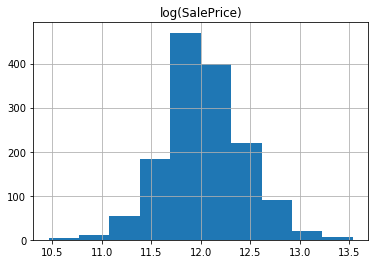

In [17]:
# Check log transform - looks good
%matplotlib inline
train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
train['SalePrice'] = train['SalePrice'].log()
print(train[0:3, 'SalePrice'])

#### Split training data

In [18]:
base_train, base_valid, stack_train, stack_valid = train.split_frame([0.3, 0.2, 0.3], seed=12345)
print(base_train.shape)
print(base_valid.shape)
print(stack_train.shape)
print(stack_valid.shape)

(441, 3205)
(297, 3205)
(425, 3205)
(297, 3205)


#### Define model with grid search function

In [19]:
def glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    hyper_parameters = {"alpha":alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="gaussian",
            lambda_search=True,
            seed=12345),
        hyper_params=hyper_parameters)
    
    # train grid
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # show grid search results
    print(grid.show())

    best = grid.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')
    
    # select best model
    return best


## Train base level models

#### First model on original numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.25]  Grid_GLM_py_191_sid_ad7f_model_python_1496413735077_1_model_1   
1     [0.5]  Grid_GLM_py_191_sid_ad7f_model_python_1496413735077_1_model_2   
2    [0.99]  Grid_GLM_py_191_sid_ad7f_model_python_1496413735077_1_model_3   
3    [0.01]  Grid_GLM_py_191_sid_ad7f_model_python_1496413735077_1_model_0   

    residual_deviance  
0  6.1547872644674975  
1   6.176742787271316  
2   6.187774564130353  
3   6.222185404213093  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_191_sid_ad7f_model_python_1496413735077_1_model_1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.030433677244580237
RMSE: 0.17445250713182725
MAE: 0.1194447728643846
RMSLE: 0.01342079219234599
R^2: 0.8278683153607946
Mean Residual Deviance: 0.030433677244580237
Null degrees of fr

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-02 10:33:10,0.000 sec,0,.13E1,2,0.1715065,0.1442587
,2017-06-02 10:33:10,0.002 sec,0,.12E1,2,0.1663340,0.1395944
,2017-06-02 10:33:10,0.004 sec,0,.12E1,2,0.1612922,0.1350533
,2017-06-02 10:33:10,0.007 sec,0,.11E1,2,0.1563858,0.1306395
,2017-06-02 10:33:10,0.009 sec,0,.11E1,2,0.1516189,0.1263565
---,---,---,---,---,---,---,---
,2017-06-02 10:33:10,0.289 sec,0,.16E-1,26,0.0300759,0.0207583
,2017-06-02 10:33:10,0.292 sec,0,.16E-1,26,0.0300370,0.0207626
,2017-06-02 10:33:10,0.295 sec,0,.15E-1,26,0.0300004,0.0207676
,2017-06-02 10:33:10,0.299 sec,0,.14E-1,26,0.0299672,0.0207743



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
12.109,12.2194
11.7745,12.1191
11.964,11.8372
12.6925,12.6562
11.9447,11.9856
12.1002,12.2708
12.6411,12.6413
11.8776,11.8451
11.7772,11.7651
12.428,12.3933


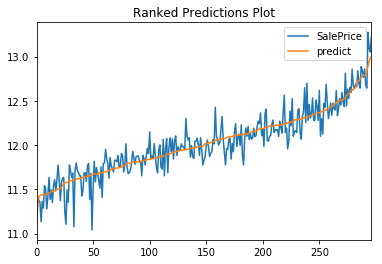

In [20]:
glm0 = glm_grid(original_nums, 'SalePrice', base_train, base_valid)

#### Second model on encoded numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.25]  Grid_GLM_py_191_sid_ad7f_model_python_1496413735077_2_model_1   
1     [0.5]  Grid_GLM_py_191_sid_ad7f_model_python_1496413735077_2_model_2   
2    [0.99]  Grid_GLM_py_191_sid_ad7f_model_python_1496413735077_2_model_3   
3    [0.01]  Grid_GLM_py_191_sid_ad7f_model_python_1496413735077_2_model_0   

   residual_deviance  
0  4.778509733930591  
1  4.789724936182832  
2  4.795613468131964  
3  4.835497149789076  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_191_sid_ad7f_model_python_1496413735077_2_model_1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.01995776379704142
RMSE: 0.14127194978848923
MAE: 0.10076704919704163
RMSLE: 0.010921613372508916
R^2: 0.8871196708696163
Mean Residual Deviance: 0.01995776379704142
Null degrees of freedom

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-02 10:33:22,0.000 sec,0,.13E1,2,0.1715065,0.1442587
,2017-06-02 10:33:22,0.003 sec,0,.12E1,2,0.1663340,0.1395944
,2017-06-02 10:33:23,0.007 sec,0,.12E1,3,0.1602977,0.1341616
,2017-06-02 10:33:23,0.015 sec,0,.11E1,3,0.1536219,0.1281660
,2017-06-02 10:33:23,0.018 sec,0,.11E1,3,0.1472498,0.1224546
---,---,---,---,---,---,---,---
,2017-06-02 10:33:23,0.358 sec,0,.16E-1,58,0.0191637,0.0162324
,2017-06-02 10:33:23,0.364 sec,0,.16E-1,58,0.0190535,0.0162727
,2017-06-02 10:33:23,0.367 sec,0,.15E-1,60,0.0189494,0.0163243
,2017-06-02 10:33:23,0.369 sec,0,.14E-1,60,0.0188553,0.0163773



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
12.109,12.2128
11.7745,11.8758
11.964,11.8285
12.6925,12.7849
11.9447,11.9533
12.1002,12.2236
12.6411,12.7159
11.8776,11.9758
11.7772,11.9094
12.428,12.36


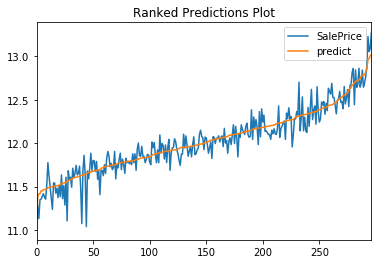

In [21]:
glm1 = glm_grid(encoded_nums, 'SalePrice', base_train, base_valid)

#### Third model on encoded numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.01]  Grid_GLM_py_191_sid_ad7f_model_python_1496413735077_3_model_0   
1     [0.5]  Grid_GLM_py_191_sid_ad7f_model_python_1496413735077_3_model_2   
2    [0.25]  Grid_GLM_py_191_sid_ad7f_model_python_1496413735077_3_model_1   
3    [0.99]  Grid_GLM_py_191_sid_ad7f_model_python_1496413735077_3_model_3   

    residual_deviance  
0  4.0943604323083775  
1   4.138301163096111  
2   4.143382514736944  
3  4.1604492333835115  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_191_sid_ad7f_model_python_1496413735077_3_model_0


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.012603422523532314
RMSE: 0.11226496569959978
MAE: 0.08035714352184414
RMSLE: 0.008763262705780909
R^2: 0.9287155366155542
Mean Residual Deviance: 0.012603422523532314
Null degrees of 

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-02 10:33:32,0.000 sec,0,.33E2,29,0.1743073,0.1468127
,2017-06-02 10:33:32,0.061 sec,0,.32E2,44,0.1688014,0.1419173
,2017-06-02 10:33:33,0.127 sec,0,.3E2,69,0.1619395,0.1358361
,2017-06-02 10:33:33,0.223 sec,0,.29E2,92,0.1543330,0.1290875
,2017-06-02 10:33:33,0.336 sec,0,.28E2,114,0.1464834,0.1221367
---,---,---,---,---,---,---,---
,2017-06-02 10:34:00,27.338 sec,0,.42E0,658,0.0127863,0.0137863
,2017-06-02 10:34:00,27.873 sec,0,.4E0,663,0.0126034,0.0137857
,2017-06-02 10:34:01,28.392 sec,0,.38E0,663,0.0124180,0.0137907
,2017-06-02 10:34:01,28.921 sec,0,.37E0,659,0.0122346,0.0137912



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
12.109,12.2061
11.7745,11.8456
11.964,11.7426
12.6925,12.7839
11.9447,11.9248
12.1002,12.1828
12.6411,12.6825
11.8776,11.9061
11.7772,11.8163
12.428,12.39


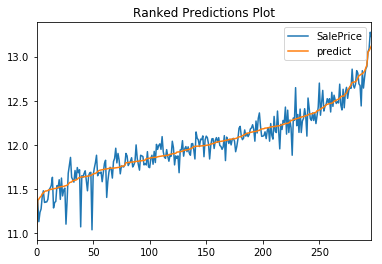

In [22]:
glm2 = glm_grid(encoded_combined_nums, 'SalePrice', base_train, base_valid)

## Train combiner model on second level data

#### Add prediction features to second level data and test data

In [23]:
stack_train = stack_train.cbind(glm0.predict(stack_train))
stack_valid = stack_valid.cbind(glm0.predict(stack_valid))
stack_train = stack_train.cbind(glm1.predict(stack_train))
stack_valid = stack_valid.cbind(glm1.predict(stack_valid))
stack_train = stack_train.cbind(glm2.predict(stack_train))
stack_valid = stack_valid.cbind(glm2.predict(stack_valid))

test = test.cbind(glm0.predict(test))
test = test.cbind(glm1.predict(test))
test = test.cbind(glm2.predict(test))

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


#### Train stack model

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.25]  Grid_GLM_py_213_sid_ad7f_model_python_1496413735077_4_model_1   
1    [0.01]  Grid_GLM_py_213_sid_ad7f_model_python_1496413735077_4_model_0   
2     [0.5]  Grid_GLM_py_213_sid_ad7f_model_python_1496413735077_4_model_2   
3    [0.99]  Grid_GLM_py_213_sid_ad7f_model_python_1496413735077_4_model_3   

    residual_deviance  
0   3.704621196014203  
1   3.720714268500598  
2  3.7227306472101565  
3  3.7493891416467346  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_213_sid_ad7f_model_python_1496413735077_4_model_1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.009232196511682757
RMSE: 0.09608431980132219
MAE: 0.06923205054905514
RMSLE: 0.007504231447023439
R^2: 0.9366679452238128
Mean Residual Deviance: 0.009232196511682757
Null degrees of 

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-02 10:35:20,0.000 sec,0,.14E1,3,0.1388564,0.1558120
,2017-06-02 10:35:20,0.054 sec,0,.13E1,4,0.1307107,0.1468813
,2017-06-02 10:35:20,0.110 sec,0,.13E1,4,0.1229066,0.1383245
,2017-06-02 10:35:20,0.165 sec,0,.12E1,4,0.1155548,0.1302545
,2017-06-02 10:35:20,0.221 sec,0,.11E1,4,0.1086306,0.1226440
---,---,---,---,---,---,---,---
,2017-06-02 10:35:29,8.486 sec,0,.17E-1,113,0.0091227,0.0124819
,2017-06-02 10:35:29,8.653 sec,0,.17E-1,112,0.0090063,0.0124859
,2017-06-02 10:35:29,8.829 sec,0,.16E-1,111,0.0088991,0.0124833
,2017-06-02 10:35:29,9.004 sec,0,.15E-1,115,0.0087968,0.0124833



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.0678
12.2061,12.3727
11.9117,12.0015
11.9767,11.9516
11.8451,11.8503
11.914,11.7571
11.8565,11.7275
12.6758,12.4637
12.861,12.5652
12.1035,12.1022


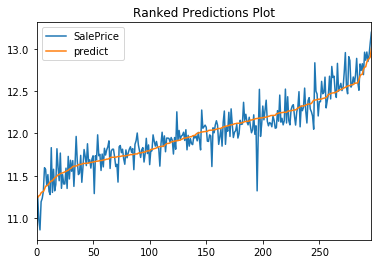

In [24]:
glm3 = glm_grid(encoded_combined_nums + ['predict', 'predict0', 'predict1'], 'SalePrice', stack_train, stack_valid)

#### Score test data

In [25]:
sub = test['Id'].cbind(glm3.predict(test))
sub['predict'] = sub['predict'].exp()
print(sub.head())

glm prediction progress: |████████████████████████████████████████████████| 100%


Id,predict
1461,110945
1462,147110
1463,163448
1464,191425
1465,188268
1466,165023
1467,178919
1468,158472
1469,185652
1470,118627


#### Create submission

In [26]:
# create time stamp
import re
import time
time_stamp = re.sub('[: ]', '_', time.asctime())

# save file for submission
sub.columns = ['Id', 'SalePrice']
sub_fname = '../KaggleHousePrices/submission_' + str(time_stamp) + '.csv'
h2o.download_csv(sub, sub_fname)

In [27]:
# Shutdown H2O - this will erase all your unsaved frames and models in H2O
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? Y
H2O session _sid_ad7f closed.
